# Content
- [Load Python Pakages](#1)
- [First look to data](#2)
- [Feature Engineering](#3)
- [Exploratory Data Analysis](#4)
- [Models and predictions](#5)
- [Aggregation of results and compilation submission csv](#6)

<a id = "1"></a><br>
# Load Python Pakages

In [577]:
# Basics
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Algorithms
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV

<a id = "2"></a><br>
#  First look to data

In [578]:
train_df = pd.read_csv('data/train.csv', index_col='Id')
test_df = pd.read_csv('data/test.csv', index_col='Id')
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [579]:
# Numerical feature descriptive statistics
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


In [580]:
# Categorical feature descriptive statistics
train_df.describe(include='object').T.sort_values(by=['unique'], ascending=False)

,count,unique,top,freq
Neighborhood,1460,25,NAmes,225
Exterior2nd,1460,16,VinylSd,504
Exterior1st,1460,15,VinylSd,515
SaleType,1460,9,WD,1267
Condition1,1460,9,Norm,1260
Condition2,1460,8,Norm,1445
HouseStyle,1460,8,1Story,726
RoofMatl,1460,8,CompShg,1434
Functional,1460,7,Typ,1360
BsmtFinType2,1422,6,Unf,1256


## Missing values

There are many missing values, let's count them

In [581]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing != 0).any(axis=1)]
missing["percent"] = missing / 1460
missing

,count,percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


Let's take care of the missing values as follows:

* Fill in all the missing entries in numeric objects with the median value
* Fill in all the missing entries in categorical objects with the fashion value

But before that, let's do Feature Engineering

Let's create a common data frame. To do this, add the SalePrice field to the test data

In [582]:
test_df['SalePrice'] = 0

And concatenate two datasets

In [583]:
train_size = train_df.shape[0]  # It will be useful later to restore data frames
all_data = pd.concat([train_df, test_df], axis=0)

<a id = "3"></a><br>
# Feature Engineering

In [584]:
all_data["LackOfFeatureIndex"] = all_data.isnull().sum(axis=1)  # Number of NaN values
all_data["MiscFeatureExtended"] = (all_data["PoolQC"].notnull().astype(int) + all_data["MiscFeature"].notnull().astype(int) + all_data["Fence"].notnull().astype(int))  # Is there PoolQC, MiscFeature, Fence
all_data["HasAlley"] = all_data["Alley"].notnull()  # Is there an alley
all_data["LotOccupation"] = all_data["GrLivArea"] / all_data["LotArea"]  # The ratio of the area occupied by the house to the entire area of the plot
all_data["NumberOfFloors"] = (all_data[["TotalBsmtSF", "1stFlrSF", "2ndFlrSF"]] != 0).sum(axis=1)  # The number of floors considering the basement
all_data['TotalCloseLiveArea'] = all_data['GrLivArea'] + all_data['TotalBsmtSF']  # The area inside the house
all_data['OutsideLiveArea'] =  all_data['WoodDeckSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch']+ all_data['3SsnPorch'] + all_data['ScreenPorch']  # The area outside the house
all_data['TotalUsableArea'] = all_data['TotalCloseLiveArea'] + all_data['OutsideLiveArea']  # Total area
all_data['AreaQualityIndicator'] = all_data['TotalUsableArea'] * all_data['OverallQual']  # Assessment of the quality of the entire area
all_data['AreaQualityCondIndicator'] = all_data['AreaQualityIndicator'] * all_data['OverallCond']  # Assessment of the quality of the entire area and the house
all_data['TotalBath'] = all_data['FullBath'] + 0.5 * all_data['HalfBath'] + all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath']  # Number of baths
all_data["HasGarage"] = all_data["GarageYrBlt"].notnull()  # Is there a garage
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']  # The general age of the house
all_data["IsRemodeled"] = all_data["YearBuilt"] != all_data["YearRemodAdd"]  # Has the house been renovated
all_data['HasBsmt'] = all_data['BsmtQual'].notnull()  # Is there a basement
all_data['QualityCondititionMul'] = all_data['OverallQual'] * all_data['OverallCond']  # General assessment of the quality of the house. Composition
all_data['Quality_condititionSum'] = all_data['OverallQual'] + all_data['OverallCond']  # General assessment of the quality of the house. The amount
all_data['HouseAgeBeforeReconstruction'] = all_data['YrSold'] - all_data['YearRemodAdd']  # The age of the house before reconstruction

Let's remove those features that are mostly empty

In [585]:
all_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'LotFrontage'], axis=1, inplace=True)

And now you can fill in all the blanks

In [586]:
for col in all_data.columns:
    if all_data[col].dtype != 'object':
        all_data[col] = all_data[col].fillna(all_data[col].median())
    else:
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

Convert categorical variable into dummy/indicator variables

In [587]:
all_data = pd.get_dummies(all_data)

Divide it back into two data frames

In [588]:
train_df = all_data.iloc[:train_size]
test_df = all_data.iloc[train_size:]

We will immediately return the text selection to its previous state (without SalePrice)

In [589]:
test_df.drop('SalePrice', axis=1, inplace=True)

C:\Users\Daniil\AppData\Local\Temp\ipykernel_7924\2935438127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop('SalePrice', axis=1, inplace=True)


<a id = "4"></a><br>
# Exploratory Data Analysis

Let’s obsorve how target variable changes with features.

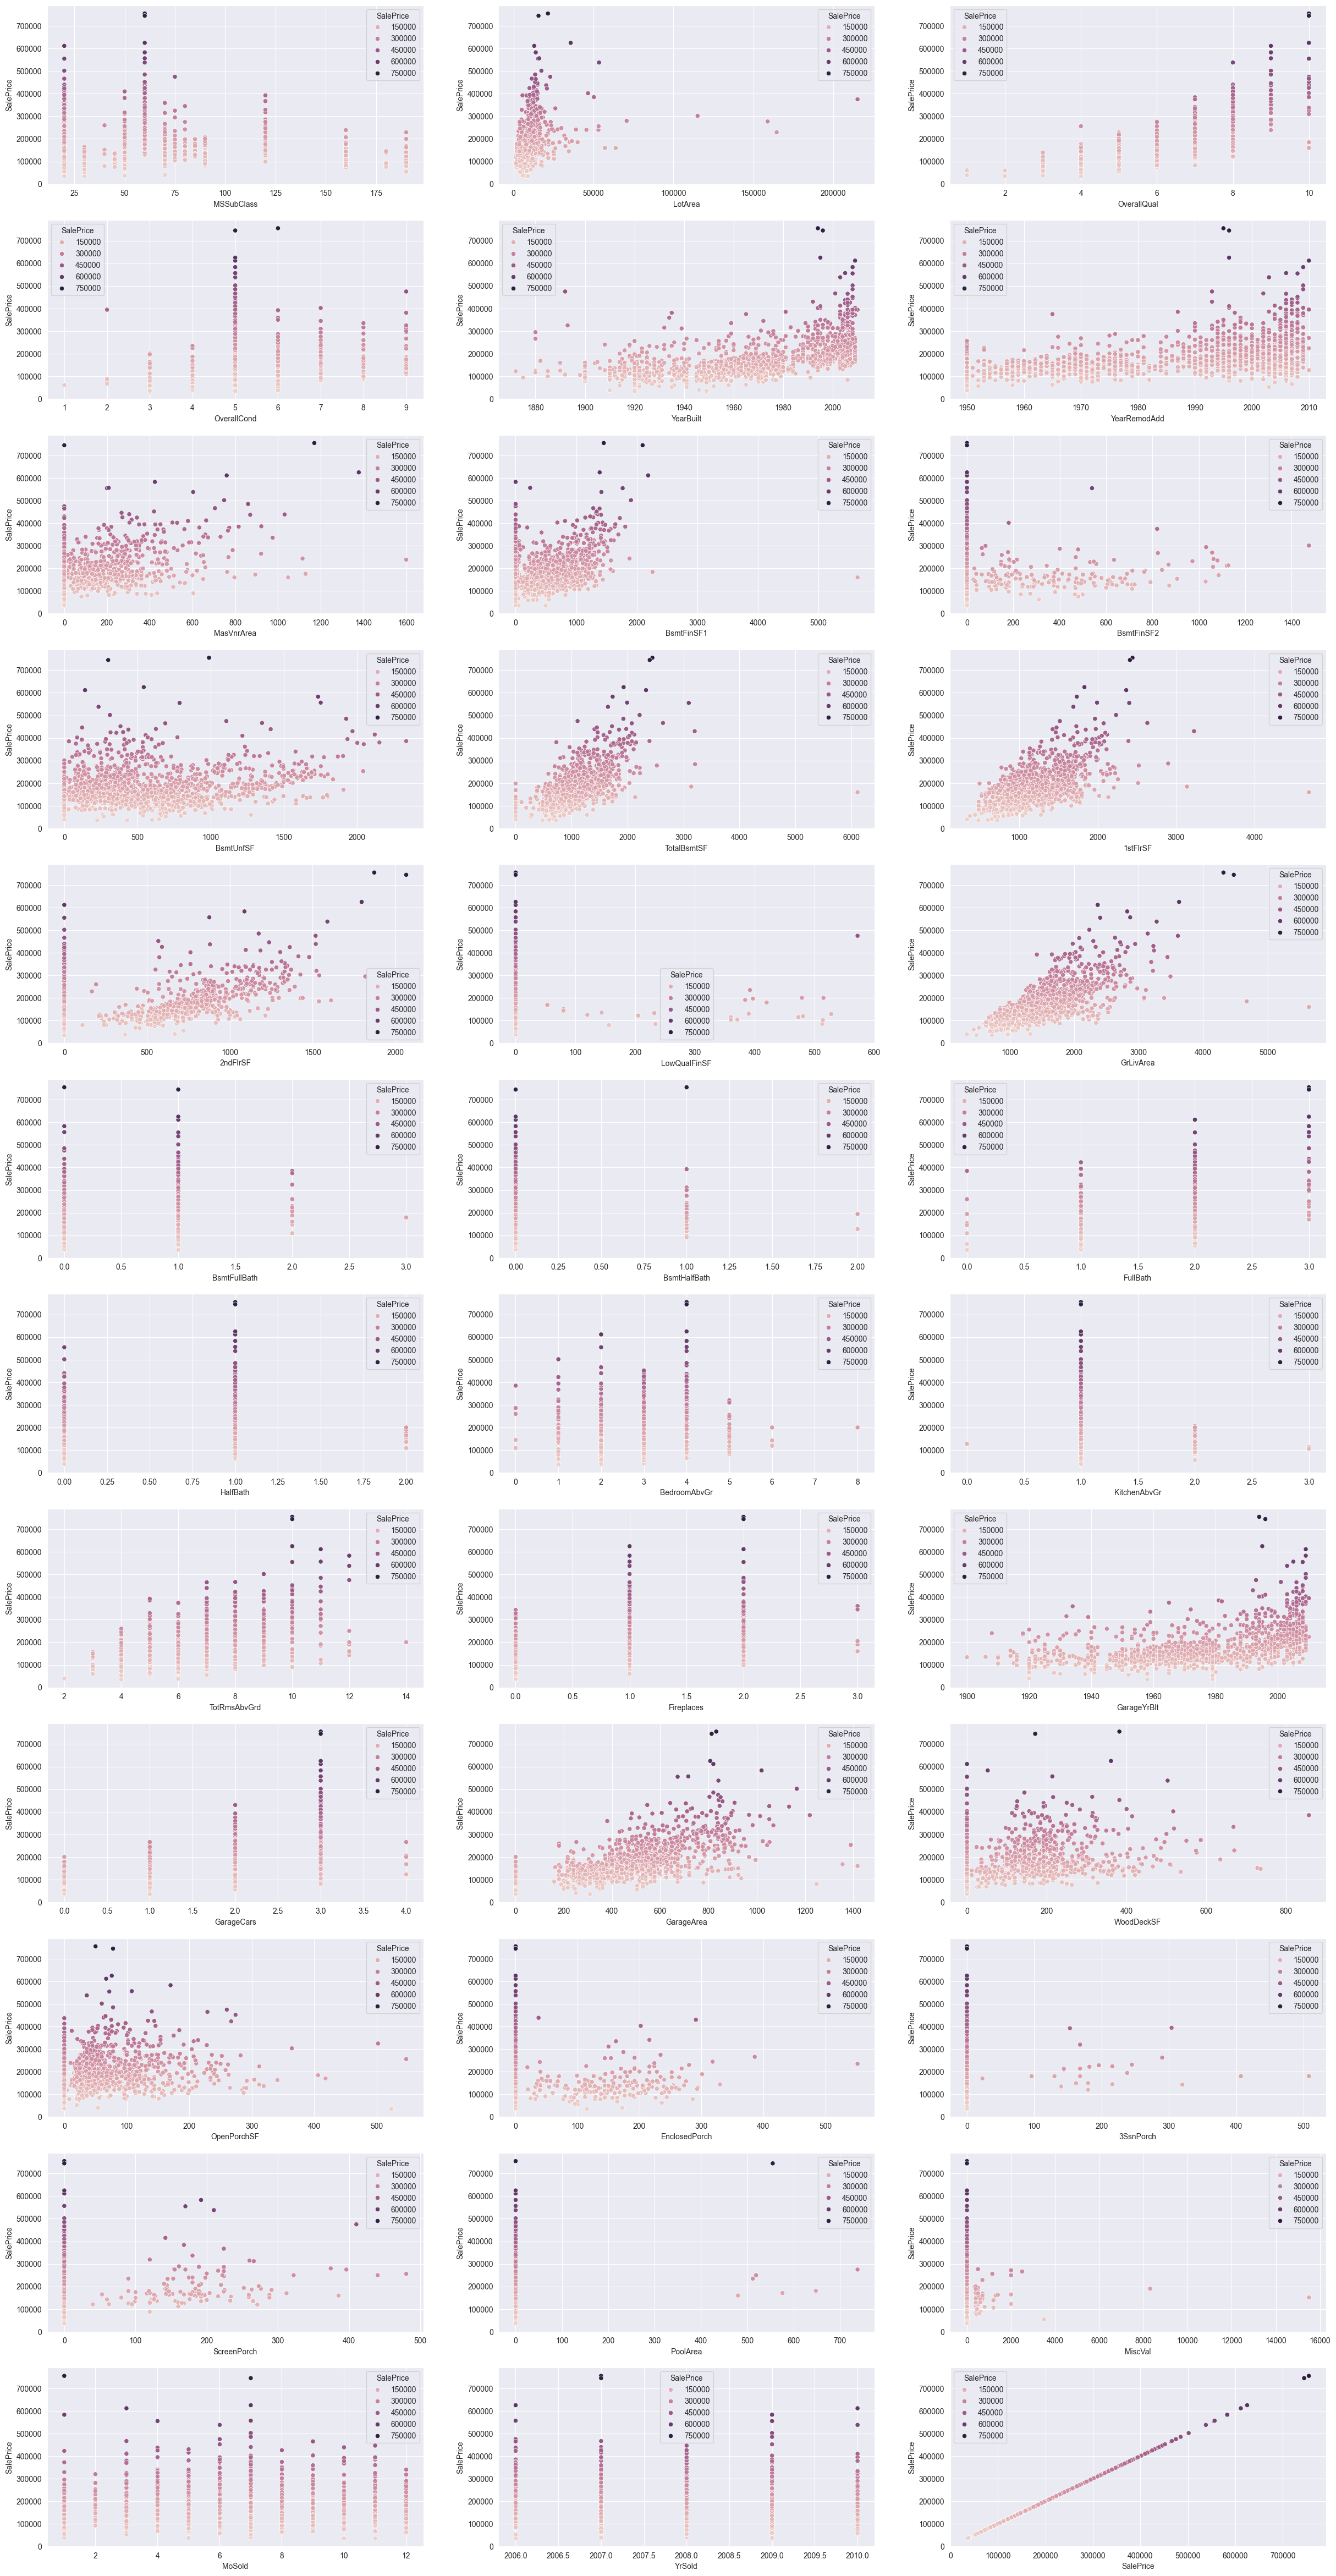

In [590]:
numerical_features = train_df.select_dtypes(include=['number'])
fig, ax = plt.subplots(12, 3, figsize=(30, 60))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.scatterplot(x=var, y='SalePrice', data=train_df, ax=subplot, hue='SalePrice')

There are some outliers in the data set. Let's drop them.

In [591]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 200000)].index)
train_df = train_df.drop(train_df[(train_df['GarageArea'] > 1200) & (train_df['SalePrice'] < 300000)].index)
train_df = train_df.drop(train_df[(train_df['TotalBsmtSF'] > 4000) & (train_df['SalePrice'] < 200000)].index)
train_df = train_df.drop(train_df[(train_df['1stFlrSF'] > 4000) & (train_df['SalePrice'] < 200000)].index)
train_df = train_df.drop(train_df[(train_df['TotRmsAbvGrd'] > 12) & (train_df['SalePrice'] < 230000)].index)

Let's allocate data for training models

In [592]:
y = train_df.SalePrice
X = train_df.drop('SalePrice', axis=1)

<a id = "5"></a><br>
# Models and predictions

XGBRegressor

In [593]:
model_xgb = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.1,
    max_depth=2,
    max_leaves=4,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42
)

model_xgb.fit(X, y)
xgb_preds = model_xgb.predict(test_df)

RidgeCV

In [594]:
ridge_cv = RidgeCV(alphas=12.966)

ridge_cv.fit(X, y)
ridge_cv_preds = ridge_cv.predict(test_df)

<a id = "6"></a><br>
# Aggregation of results and compilation submission csv

You can record the result of one model and see the value of its metric. Let's do this with two models.
The one with a lower metric value is lying less, which means that the coefficient for its result is greater

In [595]:
result = ridge_cv_preds * 0.45 + xgb_preds * 0.55

Score: 12671, Place: 366, Top 0.33%

In [596]:
submission = {
    'Id': pd.read_csv('data/test.csv').Id.values,
    'SalePrice': result
}
solution = pd.DataFrame(submission)
solution.to_csv('submission.csv', index=False)